In [96]:
import pandas as pd

In [179]:
#train.csv is needed to separate the actual training set and testing set.

order_training = pd.read_csv("./input/train.csv")
order_prior = pd.read_csv("./input/order_products__prior.csv")
order_train = pd.read_csv("./input/order_products__train.csv")
aisles = pd.read_csv("./input/aisles.csv")
departments = pd.read_csv("./input/departments.csv")
products = pd.read_csv("./input/products.csv")

In [180]:
#create full train set list because sequential merging leaves items out

order_trainset = pd.concat([order_prior, order_train])

In [181]:
len(order_trainset)

33819106

In [186]:
dataset = order_training.merge(order_trainset, left_on='order_id', right_on='order_id')

In [187]:
dataset.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,0,2539329,1,prior,1,2,8,0.0,196,1,0
1,0,2539329,1,prior,1,2,8,0.0,14084,2,0
2,0,2539329,1,prior,1,2,8,0.0,12427,3,0
3,0,2539329,1,prior,1,2,8,0.0,26088,4,0
4,0,2539329,1,prior,1,2,8,0.0,26405,5,0


In [189]:
#full list of training data. prior to train model. train is to test the trained model.
dataset = dataset.drop(columns = 'Unnamed: 0')

datasetX = dataset[dataset['eval_set'] == 'prior']
datasetY = dataset[dataset['eval_set'] == 'train']

# datasetX.to_csv("c:/users/hello/desktop/mlfinal/clean/prior_training_data.csv")
# datasetY.to_csv("c:/users/hello/desktop/mlfinal/clean/training_data.csv")

In [190]:
datasetX.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,0.0,196,1,0
1,2539329,1,prior,1,2,8,0.0,14084,2,0
2,2539329,1,prior,1,2,8,0.0,12427,3,0
3,2539329,1,prior,1,2,8,0.0,26088,4,0
4,2539329,1,prior,1,2,8,0.0,26405,5,0


# merge all data

In [191]:
datasetX = datasetX.merge(products, left_on='product_id', right_on='product_id')
datasetX = datasetX.merge(aisles, left_on = 'aisle_id', right_on = 'aisle_id')
datasetX = datasetX.merge(departments, left_on = 'department_id', right_on = 'department_id')

In [196]:
datasetX = datasetX.drop(columns = ['eval_set','product_name','aisle'])

In [198]:
#datasetX.to_csv("c:/users/hello/desktop/mlfinal/clean/priordata_clean.csv")

In [208]:
datasetX.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,department
0,2539329,1,1,2,8,0.0,196,1,0,77,7,beverages
1,2550362,1,10,4,8,30.0,196,1,1,77,7,beverages
2,3108588,1,8,1,14,14.0,196,2,1,77,7,beverages
3,550135,1,7,1,9,20.0,196,1,1,77,7,beverages
4,2295261,1,9,1,16,0.0,196,4,1,77,7,beverages


# Create train set features

In [230]:
#Items in user profile
# count of unique items
# reorder Percentage
# total item count
# department percentage
# average days since prior order

def create_user_profile(dfset):
    user_profile = {}
    count = 1
    for i in dfset['user_id'].unique():
        print(count)
        user_profile[i] = {'unique_items': 0, 'reorder_percent': 0, 'total_item_count': 0, 
                           'department_percent': {'produce':0, 'canned goods':0, 'frozen':0, 'dairy eggs':0,
                           'dry goods pasta':0, 'snacks':0, 'bakery':0, 'meat seafood':0, 'deli':0,
                           'household':0, 'beverages':0, 'pantry':0, 'international':0, 'babies':0,
                           'breakfast':0, 'personal care':0, 'alcohol':0, 'missing':0, 'pets':0,
                           'other':0, 'bulk':0}, 
                           'prior_order_days':0}

        user_df = dfset.loc[dfset['user_id'] == i]
        user_profile[i]['unique_items'] = len(user_df['product_id'].unique()) #total unique items purchased by user
        user_profile[i]['reorder_percent'] = user_df['reordered'].sum() / len(user_df)
        user_profile[i]['total_item_count'] = len(user_df)
        user_profile[i]['prior_order_days'] = user_df['days_since_prior_order'].mean()

        for idx, row in user_df.iterrows():
            user_profile[i]['department_percent'][row.department] +=1

        for j in user_profile[i]['department_percent']:
            user_profile[i]['department_percent'][j] = user_profile[i]['department_percent'][j] / len(user_df)
    
        count+=1
    return user_profile

In [225]:
#create list of tuples from dictionary to add to dataframe

def create_user_df(user_profile_df):
    cluster_df_col = ['unique_items', 'reorder_percent', 'total_item_count', 
                      'produce', 'canned goods', 'frozen', 'dairy eggs',
     'dry goods pasta', 'snacks', 'bakery', 'meat seafood', 'deli', 
                      'household', 'beverages', 'pantry', 'international',
     'babies', 'breakfast', 'personal care', 'alcohol', 'missing', 
                      'pets', 'other', 'bulk', 'prior_order_days']

    profile_list_todf = []

    for i in user_profile_df:
        current_user = []

        current_user.append(i)

        for j in range(0,3):
            current_user.append(user_profile_df[i][cluster_df_col[j]])

        for k in range(3,24):
            current_user.append(user_profile_df[i]['department_percent'][cluster_df_col[k]])

        for l in range(24,25):
            current_user.append(user_profile_df[i][cluster_df_col[l]])

        profile_list_todf.append(tuple(current_user))

    df_user_data = pd.DataFrame(profile_list_todf, columns = ['User Id','unique_items',
                                        'reorder_percent','total_item_count','produce',
                                       'canned goods', 'frozen', 'dairy eggs',
                           'dry goods pasta', 'snacks', 'bakery', 'meat seafood', 'deli',
                           'household', 'beverages', 'pantry', 'international', 'babies',
                           'breakfast', 'personal care', 'alcohol', 'missing', 'pets',
                           'other', 'bulk', 'prior_order_days'])
    return df_user_data


In [ ]:
user_prof = create_user_profile(datasetX)

In [233]:
df_user_data = create_user_df(user_prof)

In [234]:
df_user_data.head()

,User Id,unique_items,reorder_percent,total_item_count,produce,canned goods,frozen,dairy eggs,dry goods pasta,snacks,...,international,babies,breakfast,personal care,alcohol,missing,pets,other,bulk,prior_order_days
0,1,18,0.694915,59,0.084746,0.000000,0.000000,0.220339,0.000000,0.372881,...,0.000000,0.0,0.050847,0.000000,0.000000,0.000000,0.0,0.0,0.0,18.542373
1,21,102,0.502439,205,0.146341,0.000000,0.024390,0.248780,0.004878,0.195122,...,0.009756,0.0,0.014634,0.000000,0.053659,0.000000,0.0,0.0,0.0,9.809756
2,43,88,0.401361,147,0.346939,0.061224,0.088435,0.176871,0.088435,0.006803,...,0.020408,0.0,0.040816,0.006803,0.000000,0.006803,0.0,0.0,0.0,10.190476
3,52,51,0.698225,169,0.313609,0.000000,0.000000,0.065089,0.011834,0.343195,...,0.000000,0.0,0.005917,0.000000,0.000000,0.000000,0.0,0.0,0.0,8.810651
4,67,23,0.716049,81,0.382716,0.000000,0.074074,0.049383,0.000000,0.160494,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.333333


# Clustering and Svd

In [235]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [236]:
X_user = df_user_data.iloc[:,1:]

In [238]:
X_user.head()

,unique_items,reorder_percent,total_item_count,produce,canned goods,frozen,dairy eggs,dry goods pasta,snacks,bakery,...,international,babies,breakfast,personal care,alcohol,missing,pets,other,bulk,prior_order_days
0,18,0.694915,59,0.084746,0.000000,0.000000,0.220339,0.000000,0.372881,0.000000,...,0.000000,0.0,0.050847,0.000000,0.000000,0.000000,0.0,0.0,0.0,18.542373
1,102,0.502439,205,0.146341,0.000000,0.024390,0.248780,0.004878,0.195122,0.029268,...,0.009756,0.0,0.014634,0.000000,0.053659,0.000000,0.0,0.0,0.0,9.809756
2,88,0.401361,147,0.346939,0.061224,0.088435,0.176871,0.088435,0.006803,0.027211,...,0.020408,0.0,0.040816,0.006803,0.000000,0.006803,0.0,0.0,0.0,10.190476
3,51,0.698225,169,0.313609,0.000000,0.000000,0.065089,0.011834,0.343195,0.029586,...,0.000000,0.0,0.005917,0.000000,0.000000,0.000000,0.0,0.0,0.0,8.810651
4,23,0.716049,81,0.382716,0.000000,0.074074,0.049383,0.000000,0.160494,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.333333


In [241]:
#examine explained variance ratio to determine components

svd = TruncatedSVD(n_components = 2, random_state = 221).fit(X_user)
print(svd.explained_variance_ratio_)

[0.97656691 0.02167394]


In [242]:
#transform data to N components

tsvd = TruncatedSVD(n_components = 2, random_state = 221).fit(X_user)
X_svd = tsvd.transform(X_user)

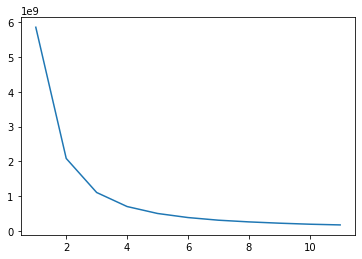

In [243]:
#example clusters for Kmeans

plotx = []
ploty = []

for i in range(1,12):   
    km_users = KMeans(n_clusters = i, random_state = 42)
    km_users.fit(X_svd)
    plotx.append(i)
    ploty.append(km_users.inertia_)
    
plt.plot(plotx, ploty)
plt.show()
 

In [245]:
#4 clusters seems to be the correct point

km_actual = KMeans(n_clusters = 4, random_state = 42)
km_actual.fit(X_svd)
cluster_output = km_actual.predict(X_svd)

In [247]:
#create output data for graphing purposes

cluster_val2 = km_actual.predict(X_svd)
svdx2 = []
svdy2 = []
for i in range(0,len(X_svd)):
    svdx2.append(X_svd[i][0])
    svdy2.append(X_svd[i][1])    

svd_cluster_df2 = pd.DataFrame(columns=['c1','c2','cluster'])
svd_cluster_df2['c1']=svdx2
svd_cluster_df2['c2']=svdy2
svd_cluster_df2['cluster']=cluster_val2

In [249]:
#svd_cluster_df2.to_csv('c:/users/hello/desktop/mlfinal/clean/train_cluster_groups.csv')

In [253]:
#df_usercluster = df_user_data[['User Id','cluster']]

In [254]:
#df_usercluster.to_csv('c:/users/hello/desktop/mlfinal/clean/user_and_cluster.csv')